# Shark Attack

## Introduction

The data came from [sharkattackfile.net](http://www.sharkattackfile.net/incidentlog.htm) and for the size of the coastline we used the data from [wikipedia](http://www.wikipedia.com/en/List_of_countries_by_length_of_coastline).

This is a short analysis of the shark attacks in the world, we will try to determine which countries are riskier.

    NOTE : English are not my mother tongue, sorry for that.

In [1]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import difflib

# Load the data
# NOTE : we are using 'skip_footer' to delete full blank rows at the end of the excel file
shark = pd.read_excel("GSAF5.xls", skip_footer=19556)
country = pd.read_csv("countries.csv",  sep=';')

%matplotlib inline

## Data Preprocessing
### Cleaning Column's Names

**Note:** If you want to use my clean data, it's available here : [shark_attack.csv](/shark_attack.csv)

In [2]:
# Checking columns
shark.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')

In [3]:
# Selecting the columns
col_to_keep = ["Date", "Year", "Type", "Country", "Activity", "Fatal (Y/N)"]
shark = shark[col_to_keep]

In [4]:
# Renaming columns names
shark = shark.rename(columns={'Fatal (Y/N)': 'Fatal'})

### Dealing With Missing and Incorrect Values

In [5]:
# Year's Column
shark[shark["Year"].isnull()]

,Date,Year,Type,Country,Activity,Fatal
10,Reported 08-Jan-2017,NaN,Invalid,AUSTRALIA,Spearfishing,NaN


In [6]:
# The Date column give us the value for Year
shark.loc[10, "Year"] = 2017

In [7]:
# Changing the type
shark["Year"] = shark["Year"].astype("int")

In [8]:
# Checking the change
shark["Year"].dtype

dtype('int64')

#### Selecting Data

(1700, 2017)

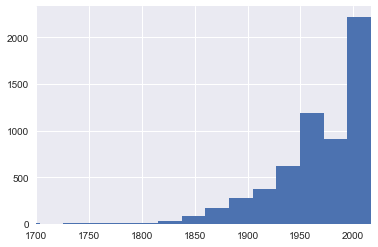

In [9]:
# Generating an histogram
plt.hist(x="Year", data=shark, bins=90)
plt.xlim([1700, shark["Year"].max()])

** NOTE : To avoid a big shunk of missing data and low quality data, we will choose to select the data from 1800 to the present day, and as you can see on the plot we don't loose too much data**

In [10]:
# Selecting the data from 1800
shark = shark[shark["Year"] >= 1800]

#### Cleaning The Fatal Column

In [11]:
# Fatal's Columns
shark["Fatal"] = shark["Fatal"].fillna("UNKNOWN")

In [12]:
shark["Fatal"].value_counts()

N                 4280
Y                 1475
UNKNOWN            109
 N                   8
F                    1
N                    1
n                    1
--M524--M3133Y       1
Name: Fatal, dtype: int64

In [13]:
# Fixing the problems
shark.loc[shark["Fatal"] == " N", "Fatal"] = "N"
shark.loc[shark["Fatal"] == "N ", "Fatal"] = "N"
shark.loc[shark["Fatal"] == "n", "Fatal"] = "N"
shark.loc[shark["Fatal"] == "F", "Fatal"] = "Y"
shark.loc[shark["Fatal"] == "--M524--M3133Y", "Fatal"] = "UNKNOWN"
shark["Fatal"].value_counts()

N          4290
Y          1476
UNKNOWN     110
Name: Fatal, dtype: int64

#### Cleaning The Country Column

In [14]:
# Country's columns 
shark["Country"] = shark["Country"].fillna("UNKNOWN")

In [15]:
# Fixing the problems
shark["Country"] = shark["Country"].fillna("UNKNOWN")
shark["Country"] = shark["Country"].str.rstrip()
shark["Country"] = shark["Country"].str.lstrip()
shark["Country"] = shark["Country"].str.replace("USA","United States")
shark["Country"] = shark["Country"].str.replace("ST. MAARTIN","SAINT MARTIN")
shark["Country"] = shark["Country"].str.replace("ST. MARTIN","SAINT MARTIN")
shark["Country"] = shark["Country"].str.replace("COLUMBIA","Colombia")
shark["Country"] = shark["Country"].str.replace("UNITED ARAB EMIRATES \(UAE\)","United Arab Emirates")
shark["Country"] = shark["Country"].str.replace("ENGLAND","United Kingdom")
shark["Country"] = shark["Country"].str.replace("SCOTLAND","United Kingdom")
shark["Country"] = shark["Country"].str.replace("(.*)\?","UNKNOWN")
shark["Country"] = shark["Country"].str.title()
shark["Country"] = shark["Country"].str.replace("Trinidad & Tobago","Trinidad and Tobago")
shark["Country"] = shark["Country"].str.replace("^(New Guinea)","Papua New Guinea")
shark["Country"] = shark["Country"].str.replace("New Britain","Papua New Guinea")

#### Cleaning The Activity Column

In [16]:
shark["Activity"].fillna("UNKNOWN")

# Function to recode activities
def code_act(a):
    if isinstance(a, str):
        a = a.lower()
        if 'surfing' in a:
            return "Surfing"
        elif 'swimming' in a:
            return "Swimming"
        elif 'fishing' in a:
            return "Fishing"
        elif 'bathing' in a:
            return "Bathing"
        elif 'wading' in a:
            return "Wading"
        elif 'diving' in a:
            return "Diving"
        else:
            return "Other"
    else:
        return "Other"

# Apply the function and recreate         
shark["Activity"] = shark["Activity"].apply(lambda x: code_act(x))

#### Cleaning The Date Column

In [17]:
# Importing the dateparser
import dateparser

In [18]:
# Fixing some of the big errors in the date column
tmp_date = shark["Date"].astype("str")
tmp_date = tmp_date.str.replace("[rR]eport.*d", "")
tmp_date = tmp_date.str.replace("\.b", "")
tmp_date = tmp_date.str.replace("\.R", "")
tmp_date = tmp_date.str.replace("\.", "-")
tmp_date = tmp_date.str.replace("190Feb", "19-Feb")
tmp_date = tmp_date.str.replace("Late ", "")
tmp_date = tmp_date.str.replace("Early ", "-")
tmp_date = tmp_date.str.replace("Mid.", "15-")
tmp_date = tmp_date.str.replace("-Ap-", "-Apr-")
tmp_date = tmp_date.str.replace("-Jut-", "-Jul-")
tmp_date = tmp_date.str.replace("23-Decp1896", "23-Dec-1896")
tmp_date = tmp_date.str.replace("Ca.", "")
tmp_date = tmp_date.str.lstrip()
tmp_date = tmp_date.str.rstrip()

In [19]:
# Applying the date parser
shark["Formated Date"] = tmp_date.apply(lambda x: dateparser.parse(x) if len(x) > 7 else np.datetime64('NaT'))

In [20]:
# Selecting data with a correct datetime
shark = shark[shark["Formated Date"].notnull()]

In [21]:
# Checking the inconsistenccy in the data between Date and Year columns
shark[shark["Year"] != shark["Formated Date"].dt.year]

,Date,Year,Type,Country,Activity,Fatal,Formated Date
493,14-May-2014,2013,Unprovoked,Ecuador,Surfing,N,2014-05-14
620,Apr-2013,2012,Unprovoked,United States,Other,N,2013-04-14
723,26-Jun-2008,2011,Unprovoked,United States,Other,N,2008-06-26
758,Reported 10-Mar-2010,2011,Invalid,Egypt,Other,N,2010-03-10
1004,06-Dec-2006,2008,Boat,Australia,Fishing,N,2006-12-06
1132,November 2011,2007,Invalid,Mexico,Diving,N,2011-11-14
2491,27-Jul-1989,1969,Invalid,Bermuda,Diving,UNKNOWN,1989-07-27
3160,01-Jan-1971,1972,Unprovoked,South Africa,Other,N,1971-01-01
3161,01-Jan-1971,1972,Unprovoked,Mozambique,Other,N,1971-01-01
3431,30-Jul-1964,1965,Provoked,Bahamas,Other,N,1964-07-30


In [22]:
# Fixing the problems and reorganizing the dataframe
shark = shark[["Formated Date", "Country", "Type", "Activity", "Fatal"]]
shark = shark.rename(columns={"Formated Date": "Date"})

### Adding Data To Complete The Analysis

In [23]:
# --- Add extra data about countries from "countries.csv"

# Selecting and renaming columns
keep_country_col = ['Country (en)', 'Country code', 'Continent', 'Population', 'Area', 'Coastline']
country = country[keep_country_col]
country = country.rename(columns={'Country (en)': 'Country'})

# function to find match between the two lists of countries
def CloseCountry(x):
    x = x.lower()
    c = country["Country"]
    r = difflib.get_close_matches(x, c, 1, 0.7)
    if not r:
        return "NO MATCH"
    else:
        return r[0]

# Applying the function    
tmp_country = shark["Country"].apply(lambda x: CloseCountry(x))
shark["NormCountry"] = shark["Country"].where(tmp_country.str[0] != shark["Country"].str[0], tmp_country)

In [24]:
# Merge the shark dataframe with the country dataframe
shark = shark.join(country[["Country", "Country code", "Continent"]].set_index("Country"), on="Country")

### Adding a New Hemesphere Column

    NOTE: This is an approximation.

In [25]:
# Function to get the hemisphere of a country
def get_hemisphere(country):
    southern_hemisphere = [
    "South Africa", "Reunion", "Mozambique", "Tanzania", "Mauritius", "Seychelles", 
    "Madagascar", "Namibia", "Mayotte", "Gabon", "Indonesia", "Brazil", "Ecuador", 
    "Argentina", "Chile", "Paraguay", "Uruguay", "Australia", "Papua New Guinea",
    "Fiji", "Papua New Guinea", "British New Guinea", "South Atlantic Ocean", "Indian Ocean", 
    "South Pacific Ocean", "Tasman Sea","Solomon Islands / Vanuatu"]
    if country in southern_hemisphere:
        return "S"
    if country == "Unknown":
        return np.nan
    else:
        return "N"

# Applying the function to create a new column "hemisphere"
shark["Hemisphere"] = shark["Country"].apply(lambda x: get_hemisphere(x))

In [26]:
# Reorganizing the dataframe and saving the clean dataframe to a csv files
shark = shark[["Date", "Country", "Country code", "Type", "Continent", "Hemisphere", "Activity", "Fatal"]]
shark.to_csv("shark_attack.csv")

In [27]:
shark["Month"] = shark["Date"].dt.month
shark["Year"] = shark["Date"].dt.year

## Analysing The Data
### Attack by Year

[<matplotlib.text.Text at 0x10eb38be0>, <matplotlib.text.Text at 0x10e76c080>]

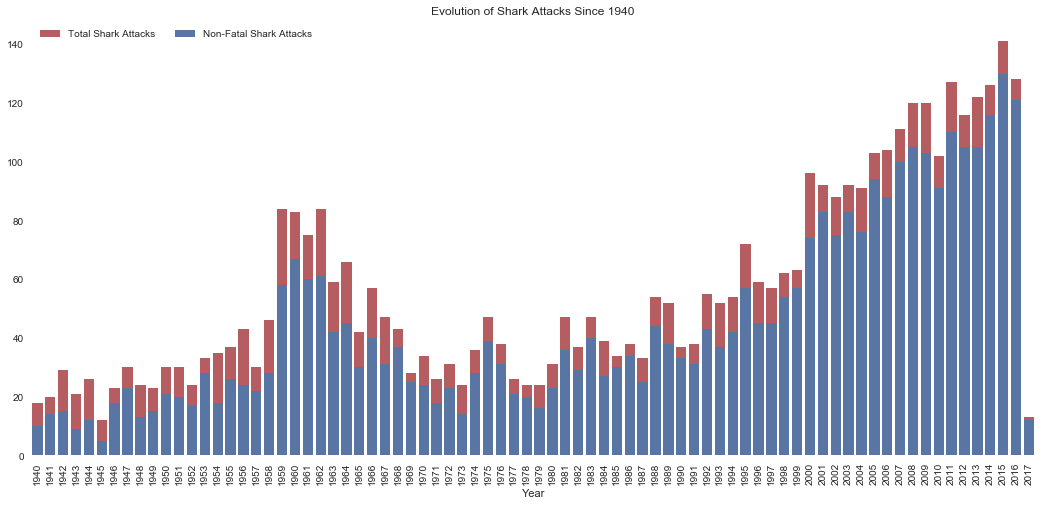

In [28]:
sns.set(style="white")
sns.color_palette("deep")
sns.set_color_codes("deep")

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(18, 8))
plt.title("Evolution of Shark Attacks Since 1940")
# Plot the total attack by year
p = sns.countplot(x="Year", data=shark[shark["Year"] >= 1940], label="Total Shark Attacks", color="r")
g = sns.countplot(x="Year", data=shark[(shark["Year"] >= 1940) & (shark["Fatal"] == "N")], 
                  label="Non-Fatal Shark Attacks", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper left", frameon=False)
p.set_xticklabels(p.get_xticklabels(), rotation=90)
sns.despine(left=True, bottom=True)
ax.set(ylabel="", xlabel="Year")

A simple analysis of the evolution of shark attacks shows us that we have more attacks since 2000-2001 than before, but we need to be careful with this conclusion, because we certainly have more data available since 2000 than before, so in reality the shape of the distribution could came from a lack of data.

### Hemisphere : Attack By Month

[<matplotlib.text.Text at 0x10eff5d68>, <matplotlib.text.Text at 0x10efed550>]

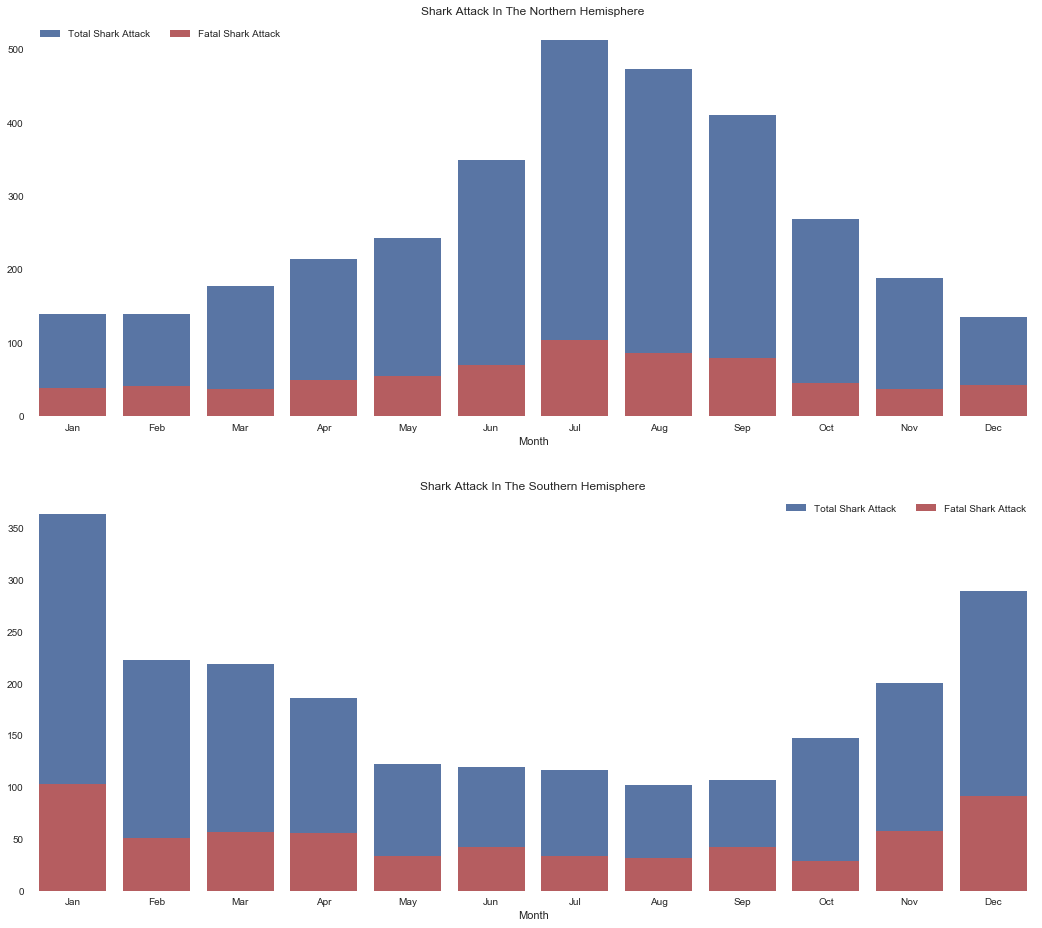

In [29]:
sns.set(style="white")
sns.color_palette("deep")
sns.set_color_codes("deep")

# Initialize the matplotlib figure
fig = plt.figure(figsize=(18, 16))
ax1 = plt.subplot(211)
plt.title("Shark Attack In The Northern Hemisphere")
ax2 = plt.subplot(212)
plt.title("Shark Attack In The Southern Hemisphere")

# Plot the total attack by Month
p = sns.countplot(x="Month", data=shark[shark["Hemisphere"] == "N"], label="Total Shark Attack", color="b", ax=ax1)
g = sns.countplot(x="Month", data=shark[(shark["Hemisphere"] == "N") & (shark["Fatal"] == "Y")], 
                  label="Fatal Shark Attack", color="r", ax=ax1)

v = sns.countplot(x="Month", data=shark[shark["Hemisphere"] == "S"], label="Total Shark Attack", color="b", ax=ax2)
d = sns.countplot(x="Month", data=shark[(shark["Hemisphere"] == "S") & (shark["Fatal"] == "Y")], 
                  label="Fatal Shark Attack", color="r", ax=ax2)

m = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Add a legend and informative axis label
ax1.legend(ncol=2, loc="upper left", frameon=False)
ax2.legend(ncol=2, loc="upper right", frameon=False)
p.set_xticklabels(m)
v.set_xticklabels(m)
sns.despine(left=True, bottom=True)
ax1.set(ylabel="", xlabel="Month")
ax2.set(ylabel="", xlabel="Month")

As we might think, (1) the Northern Hemisphere is touched by much more attacks (around 90% of the earth's total human population live in that Hemisphere) (2) we see much more attacks in summer (Jul-Aug for the Northern and Dec-Jan for the Southern). 

To summerize, as expected more people live in the Northern, so we have more attacks in that hemisphere. We see more attacks in the summer because the nautics activities is higher during that period.

### A Simple Dashboard

[<matplotlib.text.Text at 0x102dbe588>, <matplotlib.text.Text at 0x102db4d30>]

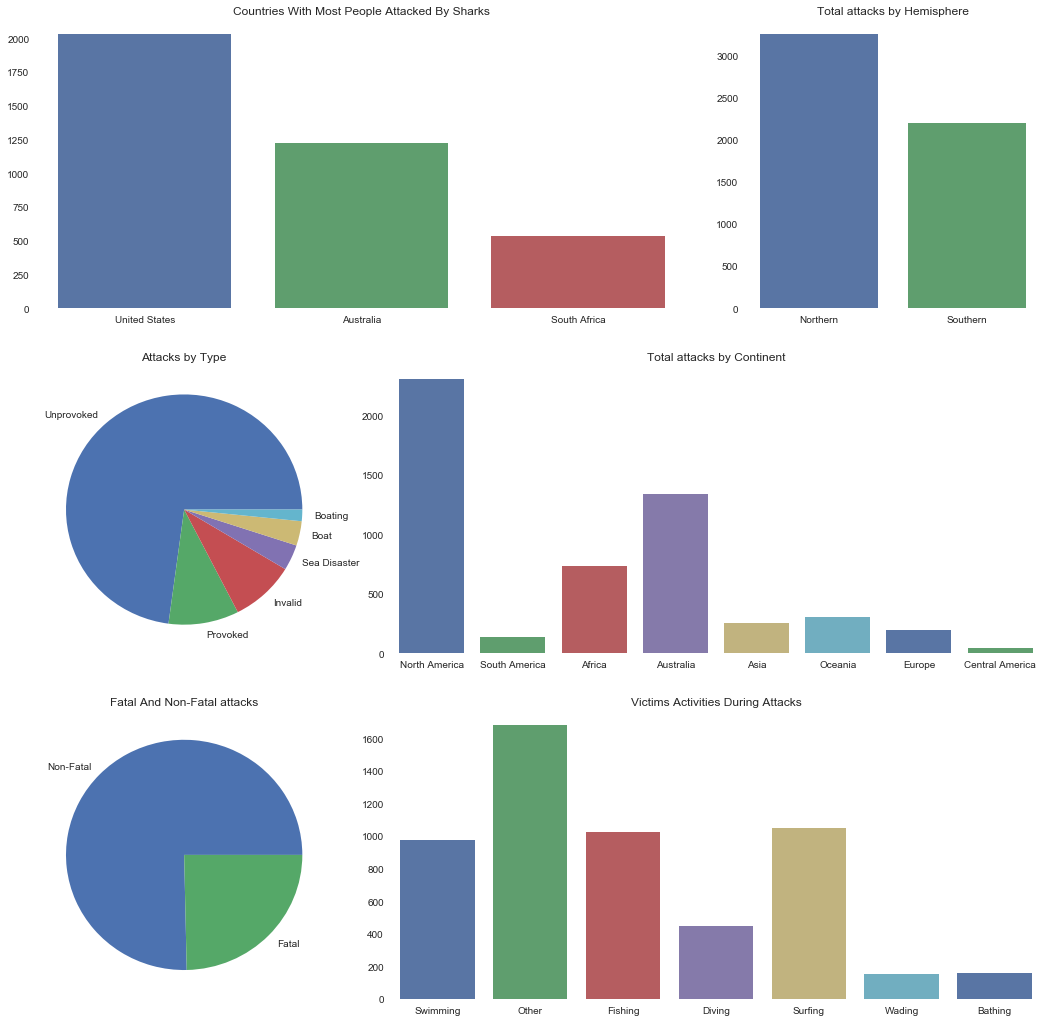

In [30]:
plt.style.use('seaborn-white')
sns.set(style="white")
sns.color_palette("deep")
sns.set_color_codes("deep")

# Initialize the matplotlib figure
fig = plt.figure(figsize=(18, 18))
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2)
plt.title('Countries With Most People Attacked By Sharks')
ax2 = plt.subplot2grid((3,3), (0,2))
plt.title('Total attacks by Hemisphere')
ax3 = plt.subplot2grid((3,3), (1,0))
ax3.pie(shark.Type.value_counts(), labels=shark.Type.value_counts().index)
plt.title('Attacks by Type')
ax4 = plt.subplot2grid((3,3), (1, 1), colspan=2)
plt.title('Total attacks by Continent')
ax5 = plt.subplot2grid((3,3), (2,0))
ax5.pie(shark[shark["Fatal"] != "UNKNOWN"].Fatal.value_counts(), labels=["Non-Fatal", "Fatal"])
plt.title('Fatal And Non-Fatal attacks')
ax6 = plt.subplot2grid((3,3), (2,1), colspan=2)
plt.title('Victims Activities During Attacks')

# Draw plots
g1 = sns.countplot(x="Country", data=shark, palette="deep", order=shark.Country.value_counts().iloc[:3].index, ax=ax1)
g2 = sns.countplot(x="Hemisphere", data=shark, palette="deep", ax=ax2)
g4 = sns.countplot(x="Continent", data=shark[shark["Continent"] != "America"], palette="deep", ax=ax4)
g6 = sns.countplot(x="Activity", data=shark, palette="deep", ax=ax6)

# Add a legend and informative axis label
sns.despine(left=True, bottom=True)
ax1.set(ylabel="", xlabel="")
ax2.set(ylabel="", xlabel="")
ax2.set_xticklabels(["Northern", "Southern"])
ax4.set(ylabel="", xlabel="")
ax6.set(ylabel="", xlabel="")

This is some basic informations about the data.
1. We see that The United States, Australia and South Africa are the three coutries with the higher number of attacks. 
2. We also see that the majority of attacks were "Unprovoked".
*For more information about the classification of the type of attacks we invit you to visit [the official website](http://www.sharkattackfile.net/incidentlog.htm).*
3. As expected, the three continents of the three countries with the highest number of attacks are the continents where there has been more attacks.
4. A vast majority of attacks were non-fatal.
5. If we exclude the "others activities", fishing, swimming and surfing were the three mains activities touched by sharks attacks.

### Analysing A Little But More "Attacks By Country"

    NOTE : Here we want to create a better indicator to compare attacks across countries.

In [31]:
# Create a new df with values we need to study (Total Attack and Fatal Attack)
total_attack_per_country = shark["Country"].value_counts()
fatal_attack_per_country = shark.loc[shark["Fatal"] == "Y","Country"].value_counts()

attack_per_country = pd.concat([total_attack_per_country, fatal_attack_per_country], axis=1)
attack_per_country.columns = ["Total Attack", "Fatal Attack"]
attack_per_country["Fatal Attack"] = attack_per_country["Fatal Attack"].fillna(0).astype("int")

In [32]:
# Merge the previous df with the country df
new_country = country.join(attack_per_country, on="Country")

In [33]:
new_country = new_country[new_country["Total Attack"].notnull()]
new_country[["Total Attack", "Fatal Attack"]] = new_country[["Total Attack", "Fatal Attack"]].astype("int")

In [34]:
# Add some corrects values
new_country.loc[new_country["Country"] == "Reunion", "Coastline"] = 419
new_country.loc[new_country["Country"] == "Martinique", "Coastline"] = 350
new_country.loc[new_country["Country"] == "Mayotte", "Coastline"] = 185
new_country.loc[new_country["Country"] == "Netherlands Antilles", "Coastline"] = 364

In [35]:
# Computing indicators
new_country["Fatal Attack in Total Attack"] = 100 * (new_country["Fatal Attack"] / new_country["Total Attack"].astype("float"))
new_country["Attack per Coastline"] = new_country["Total Attack"] / new_country["Coastline"].astype("float")
new_country["Fatal per Coastline"] = new_country["Fatal Attack"] / new_country["Coastline"].astype("float")

# Replacing Inf values resulting from divisions by zero (one case)
new_country.loc[np.isinf(new_country["Attack per Coastline"]), "Attack per Coastline"] = float(0)
new_country.loc[np.isinf(new_country["Fatal per Coastline"]), "Fatal per Coastline"] = float(0)

[<matplotlib.text.Text at 0x10c5ee0f0>, <matplotlib.text.Text at 0x10efb49b0>]

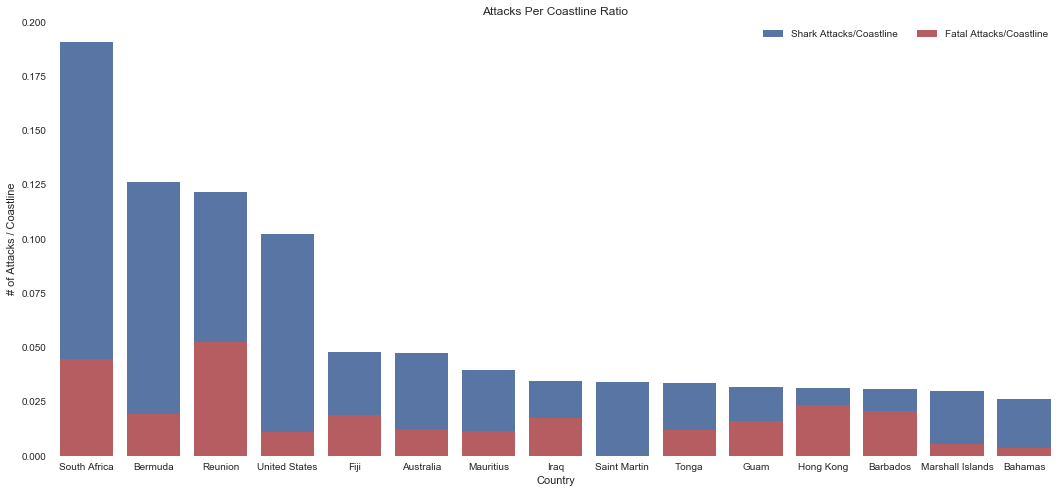

In [36]:
sns.set(style="white")
sns.color_palette("deep")
sns.set_color_codes("deep")

# Initialize the matplotlib figure
fig = plt.figure(figsize=(18, 8))
ax = plt.subplot()
plt.title("Attacks Per Coastline Ratio")

# Selecting data
top15 = new_country.sort_values(by="Attack per Coastline", ascending=False).head(15)

# Plot the total attack by Month
p = sns.barplot(x="Country", y="Attack per Coastline", data=top15, label="Shark Attacks/Coastline", color="b", ax=ax)
g = sns.barplot(x="Country", y="Fatal per Coastline", data=top15, 
                  label="Fatal Attacks/Coastline", color="r", ax=ax)

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=False)
sns.despine(left=True, bottom=True)
ax.set(ylabel="# of Attacks / Coastline", xlabel="Country")

With this indicator, we try to take into account the size of the country. Thus, we have choose to divide the number of attacks by the size of the coastline.  

As you can see, just one country (South Africa) from the three coutries with the higher number of attacks are still in it, and in fact with the new indicator (attacks per Coastline) he is now the first country in the ranking.

In term of fatal attacks, this is the Reunion Island the first, it seems that it's not a good place for swimming, surfing or fishing.

**TL;DR CONCLUSION : Top three countries in term of risk of attacks: South Africa, Bermuda and Reunion. The last one is even the riskier in term of fatality.**